In [1]:
import scanpy as sc
import anndata
import os
import fnmatch
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
#import scrublet as scr
import importlib
import sys
from harmony import harmonize
import seaborn as sns
from matplotlib import rcParams
import math
from scipy import stats
import seaborn as sns
import scipy as sp
import h5py
import warnings
import random
import math
import scvelo as scv
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
#Setting Scanpy figure parameters 
sc.settings.set_figure_params(dpi = 500, color_map = 'RdPu', dpi_save = 500)

In [4]:
adata_allcells = sc.read_h5ad("./Scanpy_H5AD/adata_Final_for_Reinfection_publication.h5ad")
adata_allcells

AnnData object with n_obs × n_vars = 88360 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int', 'CoarseClustering'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CoarseClustering_colors', 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'Subclustering_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    var

In [5]:
adata = sc.AnnData(adata_allcells.raw.X, obs=adata_allcells.obs, var=adata_allcells.raw.var, uns=adata_allcells.uns)
adata = adata[adata.obs['CoarseClustering'].isin(['Neutrophils']), :]
adata

View of AnnData object with n_obs × n_vars = 5250 × 26030
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int', 'CoarseClustering'
    var: 'n_cells', 'Blacklist_Genes'
    uns: 'CoarseClustering_colors', 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'Subclustering_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [6]:
adata.raw = adata.copy()
# keep blacklist genes from vars (they are stored in .raw so still accessible)
adata = adata[:,~adata.var['Blacklist_Genes']]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata.var['highly_variable'].value_counts()
adata

AnnData object with n_obs × n_vars = 5250 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int', 'CoarseClustering'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CoarseClustering_colors', 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'Subclustering_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [7]:
list(set(adata.obs.Subclustering))

['SORL1$^{hi}$, CFD$^{hi}$  Neutrophils',
 'ICAM1$^{hi}$, NBN$^{hi}$ Neutrophils']

# Plot cluster defining genes

In [8]:
adata_NEW_2 = sc.AnnData(adata.raw.X, obs=adata.obs, var=adata.raw.var, uns=adata.uns)
sc.pp.normalize_per_cell(adata_NEW_2, counts_per_cell_after=1e4)
sc.pp.log1p(adata_NEW_2)
sc.pp.highly_variable_genes(adata_NEW_2, n_top_genes=2000)
print(adata_NEW_2.var['highly_variable'].value_counts())  
adata_scaled = sc.pp.scale(adata_NEW_2, copy=True)  
adata_NEW_2.layers['scaled'] = adata_scaled.X  

False    24029
True      2001
Name: highly_variable, dtype: int64


In [9]:
pd.set_option('display.max_columns', None)
sc.tl.rank_genes_groups(adata_NEW_2, 'Subclustering', method='wilcoxon')
display(pd.DataFrame(adata_NEW_2.uns['rank_genes_groups']['names']).head(50))


,"ICAM1$^{hi}$, NBN$^{hi}$ Neutrophils","SORL1$^{hi}$, CFD$^{hi}$ Neutrophils"
0,ICAM1,SORL1
1,NBN,CFD
2,LOC102118223,PLBD1
3,IDO1,SELL
4,CD83,XPO6
5,LOC102146847,LOC102139186
6,NFKBIA,LOC102126493
7,SLC43A3,RNF149
8,GADD45B,RGS2
9,FAS,S100A9


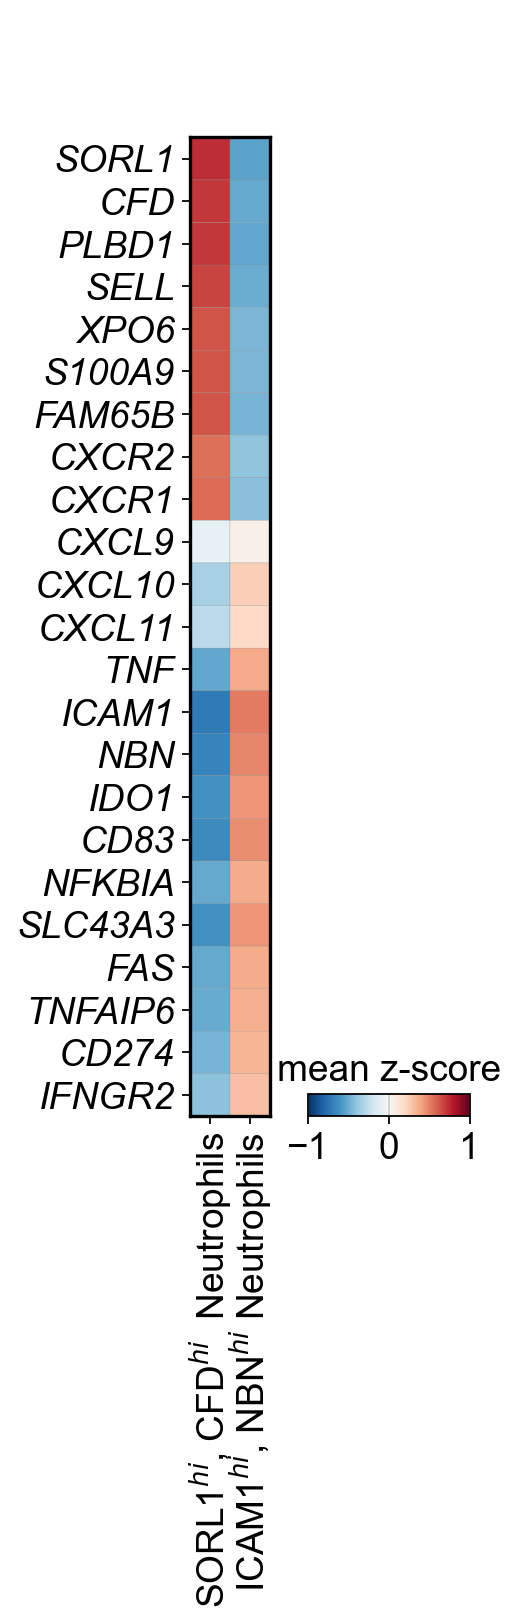

In [11]:
sc.set_figure_params(scanpy=True, fontsize=20)
Marker_Genes=["SORL1","CFD","PLBD1","SELL","XPO6","S100A9","FAM65B","CXCR2","CXCR1",
             "CXCL9","CXCL10","CXCL11","TNF",
                 "ICAM1","NBN","IDO1","CD83","NFKBIA","SLC43A3","FAS","TNFAIP6","CD274","IFNGR2"


            ]

mp=sc.pl.matrixplot(adata_NEW_2, var_names=Marker_Genes,groupby= 'Subclustering',
                    categories_order=[    
'SORL1$^{hi}$, CFD$^{hi}$  Neutrophils',
 'ICAM1$^{hi}$, NBN$^{hi}$ Neutrophils'

], dendrogram=False,
colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap="RdBu_r",use_raw=True,swap_axes=True,return_fig=True)
main_ax = mp.get_axes()['mainplot_ax']
for text_obj in main_ax.get_yticklabels():
    text_obj.set_fontstyle('italic')
fig = main_ax.get_figure()
output_file_path = "./Figure6/Associated_Supplemental/Supplemental_Figure6_Heatmap_Neutrophils.png"
fig.savefig(output_file_path, dpi=1000, transparent=True, bbox_inches='tight')
plt.show()


# Plot stacked bar plots for each granuloma (not associated with main or supp figures)

In [12]:
adata

AnnData object with n_obs × n_vars = 5250 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int', 'CoarseClustering'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CoarseClustering_colors', 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'Subclustering_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [13]:
def normalized_stacked_bar_plot(adata_gran_annot, x_value, color_value, palette=None, legend=True, ax=None, x_order=None):
    if color_value+"_colors" in adata_gran_annot.uns:
        palette = colors.ListedColormap(adata_gran_annot.uns[color_value+"_colors"])
    if x_value == "Group":
        df = order_labels(adata_gran_annot.obs, x_value, ["Naïve", "IgG", "antiCD4"])
    else:
        df = adata_gran_annot.obs
    tmp = df.groupby([x_value, color_value])[color_value].count().unstack(color_value).fillna(0)
    if x_order is not None:
        tmp = tmp.reindex(x_order)
    if ax is not None:
        tmp.divide(tmp.sum(axis=1), axis=0).plot(kind='bar', stacked=True, colormap=palette, ax=ax)
    else:
        ax = tmp.divide(tmp.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(24, 8), colormap=palette)
    ax.grid(False)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    plt.ylabel("proportion of cells")
    if legend:
        plt.legend(loc='upper center', bbox_to_anchor=(1.2, 1))
    else:
        ax.legend().set_visible(False)
    ax.set_ylim(0, 1.1)


In [14]:
def stacked_bar_plot(adata,x_value,color_value, palette=None, legend=True, ax=None):
    if color_value+"_colors" in adata.uns:
        palette = colors.ListedColormap(adata.uns[color_value+"_colors"])
   
    df = adata.obs
    if ax is not None:

        df.groupby([x_value,color_value])[color_value].count().unstack(color_value).fillna(0).plot(kind='bar',stacked=True,colormap=palette, ax=ax)
    else:
        ax=df.groupby([x_value,color_value])[color_value].count().unstack(color_value).fillna(0).plot(kind='bar',stacked=True,colormap=palette)
        ax.grid(False)
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
    plt.ylabel("n_cells")
    if legend:
        plt.legend(loc='upper center', bbox_to_anchor=(1.60, 1))
    else:
        ax.legend().set_visible(False)
        ax.grid(False)

In [15]:
def stacked_bar_plot(adata, x_value, color_value, palette=None, legend=True, ax=None, x_order=None):
    if color_value+"_colors" in adata.uns:
        palette = colors.ListedColormap(adata.uns[color_value+"_colors"])
  
    df = adata.obs
    grouped_data = df.groupby([x_value, color_value])[color_value].count().unstack(color_value).fillna(0)
    
    if x_order:
        grouped_data = grouped_data.reindex(x_order)
    
    if ax is not None:
        grouped_data.plot(kind='bar', stacked=True, colormap=palette, ax=ax)
    else:
        ax = grouped_data.plot(kind='bar', stacked=True, colormap=palette)
        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(False)
        ax.yaxis.tick_right()
        
    plt.xticks(fontsize=18)
    plt.yticks(rotation=0)
    plt.ylabel("Fraction of T,NK subset", size=18)
    
    if legend:
        plt.legend(loc='upper center', bbox_to_anchor=(1.90, 1))
    else:
        ax.legend().set_visible(False)
        ax.grid(False)


In [16]:
import matplotlib.colors as colors
def grouped_stacked_bars(adata, plot_sep, x_value, color_value, normalized=True, 
                         figwidth_mult=8, figheight=7, plot_order=None):
    if plot_order:
        adata.obs[plot_sep] = adata.obs[plot_sep].astype("category")
        adata.obs[plot_sep].cat.reorder_categories(plot_order, inplace=True)
    
    nplots = len(adata.obs[plot_sep].unique())
    plot_no = 0
    fig, ax = plt.subplots(1, nplots, sharey='all', figsize=(figwidth_mult*nplots, figheight), 
                           gridspec_kw={'width_ratios': [len(set(adata.obs.loc[adata.obs[plot_sep] == p, x_value])) 
                                                         for p in adata.obs[plot_sep].cat.categories]})
    
    for p in adata.obs[plot_sep].cat.categories:
        a = adata[adata.obs[plot_sep]==p]
        if normalized:
            normalized_stacked_bar_plot(a, x_value, color_value, legend=False, ax=ax[plot_no])
        else:
            stacked_bar_plot(a, x_value, color_value, legend=False, ax=ax[plot_no])
        ax[plot_no].set_title(p)
        plot_no += 1
    
    name_to_color = {}
    for a in ax:
        handles, labels = a.get_legend_handles_labels()
        for i, h in enumerate(labels):
            name_to_color[h] = handles[i]
        a.tick_params(left=False)
        a.grid(False)
        a.set_xlabel('')
        a.set_ylabel('Fraction of T,NK subset')
        for _, spine in a.spines.items():
            spine.set_visible(True)
    
    fig.legend(name_to_color.values(), name_to_color.keys(), loc='lower center', ncol=8, bbox_to_anchor=(.55, 1))


In [17]:
def grouped_stacked_bars(adata, plot_sep, x_value, color_value, normalized=True, 
                         figwidth_mult=8, figheight=7, plot_order=None, palette=None, legend=True):
    
    def stacked_bar_plot(df, x_value, color_value, palette=None, legend=True, ax=None):
        if color_value+"_colors" in adata.uns:
            palette = colors.ListedColormap(adata.uns[color_value+"_colors"])
        if normalized:
            grouped_data = df.groupby(x_value)[color_value].value_counts(normalize=True).unstack().fillna(0)
        else:
            grouped_data = df.groupby(x_value)[color_value].value_counts(normalize=False).unstack().fillna(0)

        if not ax:
            ax = plt.gca()

        grouped_data.plot(kind='bar', stacked=True, colormap=palette, ax=ax)
        ax.grid(False)
        #need to change this y label but will leave for now
        ax.set_ylabel('Number of T,NK subset' if not normalized else 'Fraction of T,NK subset')
        #ax.yaxis.tick_right()
        #ax.yaxis.set_label_position("right")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

        if not legend:
            ax.get_legend().remove()

    if plot_order:
        adata.obs[plot_sep] = adata.obs[plot_sep].astype("category")
        adata.obs[plot_sep].cat.reorder_categories(plot_order, inplace=True)
    
    nplots = len(adata.obs[plot_sep].unique())
    fig, ax = plt.subplots(1, nplots, sharey='all', figsize=(figwidth_mult*nplots, figheight), 
                           gridspec_kw={'width_ratios': [len(set(adata.obs.loc[adata.obs[plot_sep] == p, x_value])) 
                                                         for p in adata.obs[plot_sep].cat.categories]})
    
    for plot_no, p in enumerate(adata.obs[plot_sep].cat.categories):
        a = adata[adata.obs[plot_sep] == p]
        stacked_bar_plot(a.obs, x_value, color_value, palette=palette, legend=False, ax=ax[plot_no])
        ax[plot_no].set_title(p)

    name_to_color = {}
    for a in ax:
        handles, labels = a.get_legend_handles_labels()
        for i, h in enumerate(labels):
            name_to_color[h] = handles[i]
        a.tick_params(left=False)
        a.grid(False)
        a.set_xlabel('')
        a.set_ylabel('Fraction of T,NK subset')
        for _, spine in a.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(2) 
    
    fig.legend(name_to_color.values(), name_to_color.keys(), loc='lower center', ncol=8, bbox_to_anchor=(.55, 1))
    return fig
    #plt.show()


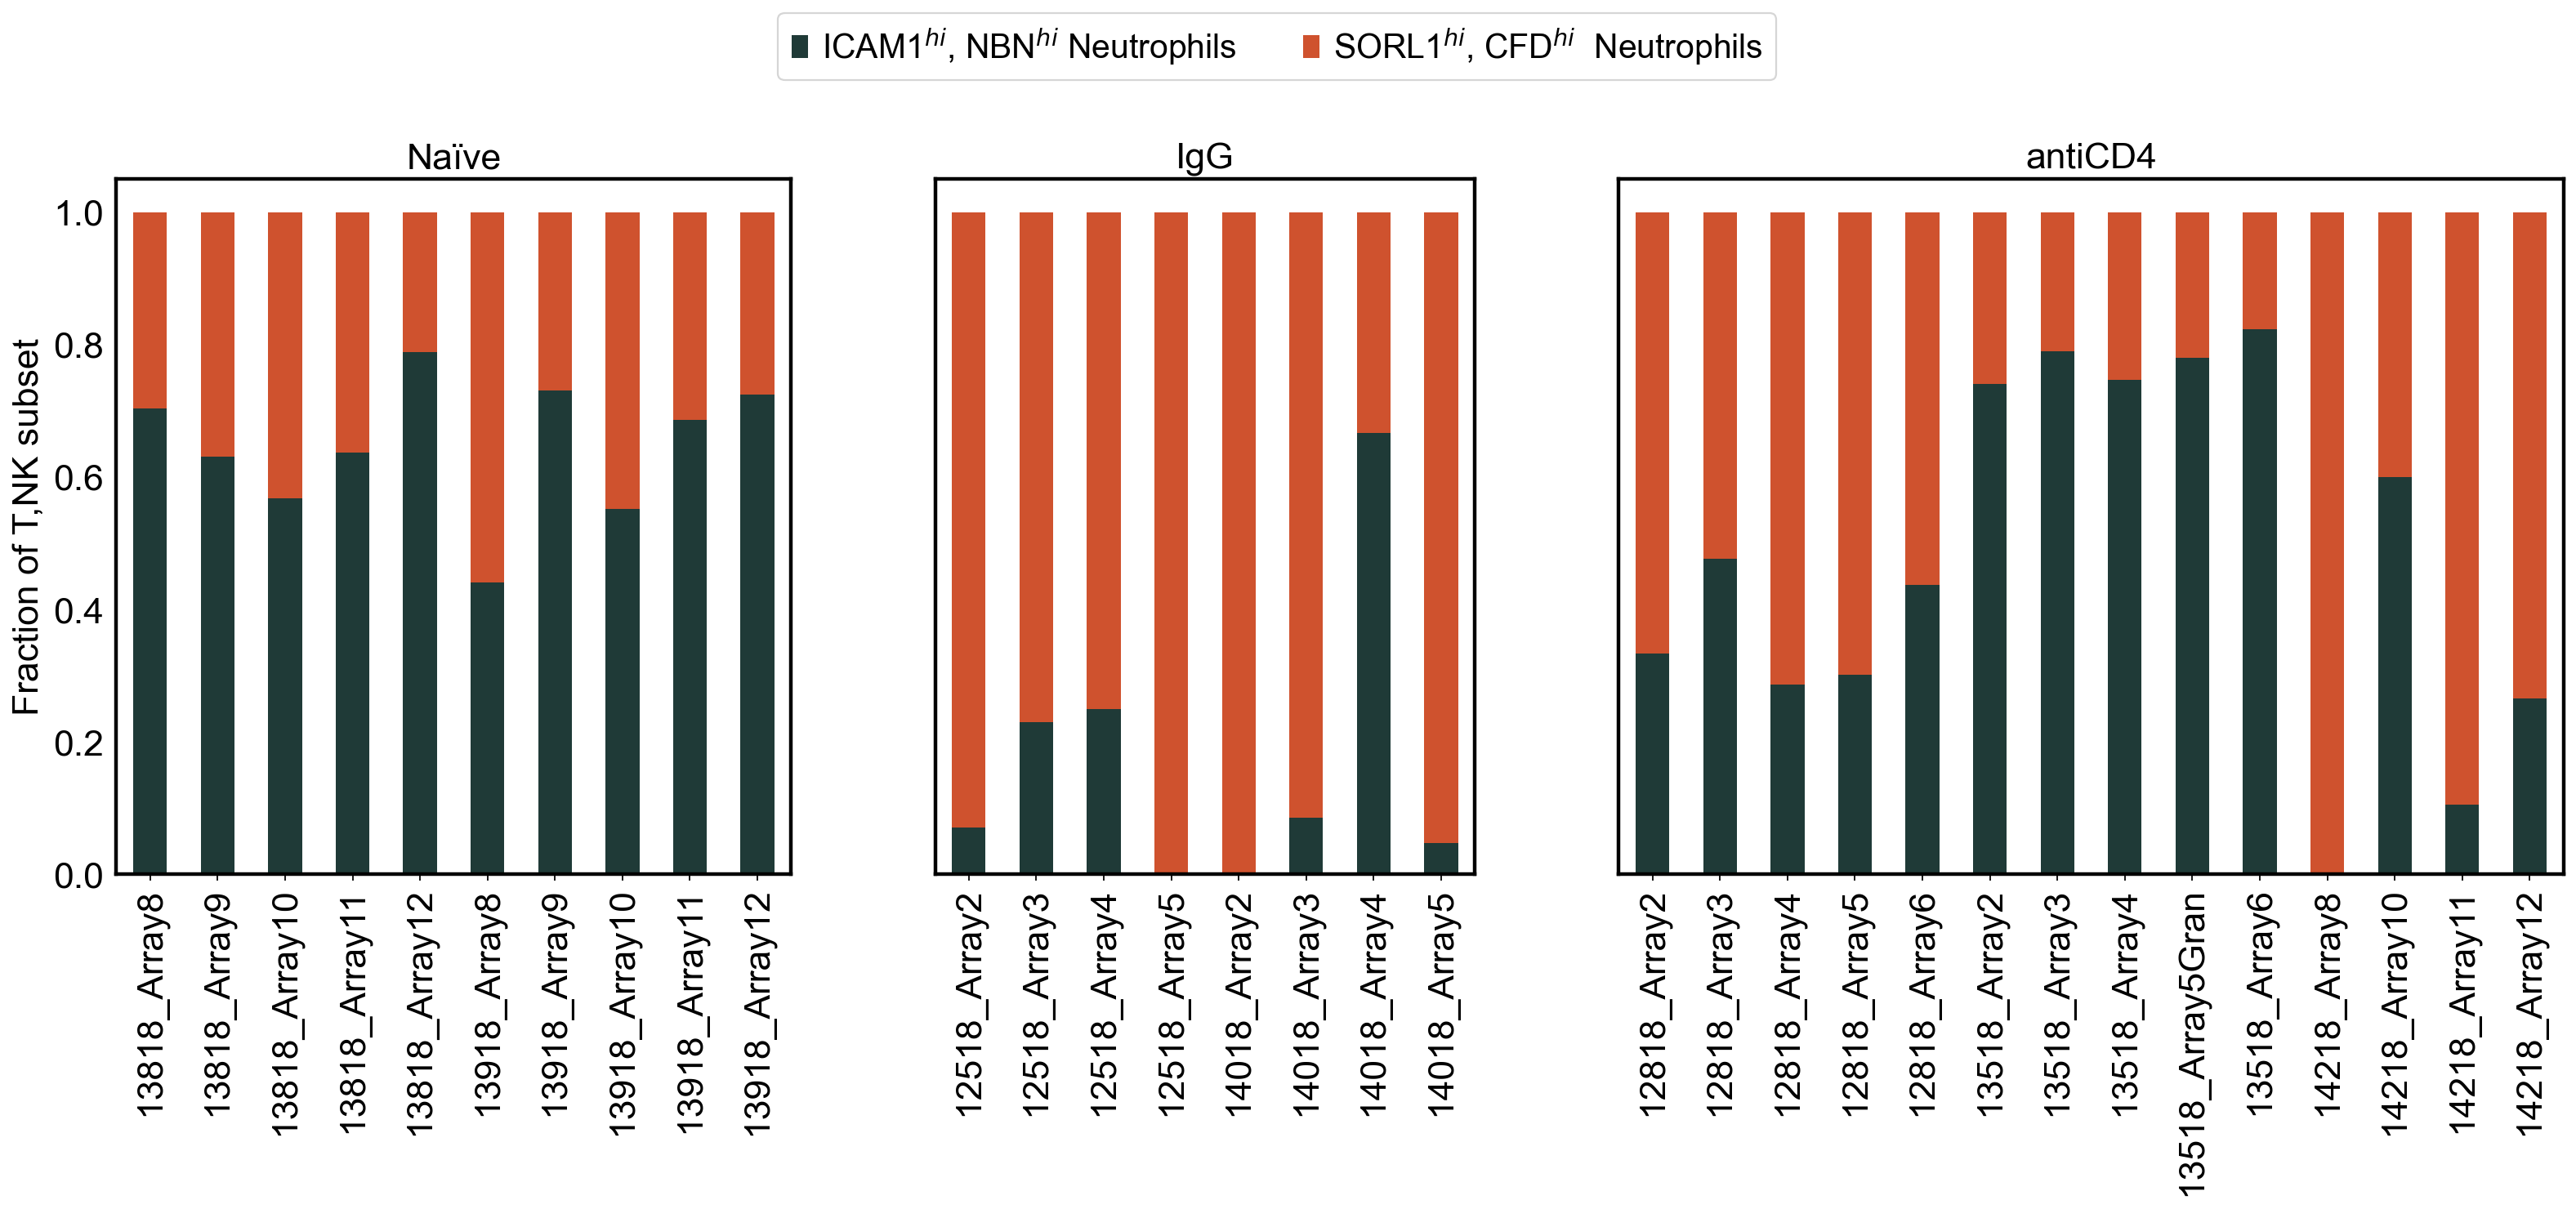

In [18]:
plt.rcParams['axes.linewidth'] = 2
grouped_stacked_bars(adata,plot_sep='Group',x_value='array number',color_value='Subclustering',plot_order=["Naïve", "IgG", "antiCD4"])
plt.savefig("./Figure6/Associated_Supplemental/Figure6_Neut_StackedBarPlot_Granuloma_Group.png",bbox_inches="tight",dpi=1000)


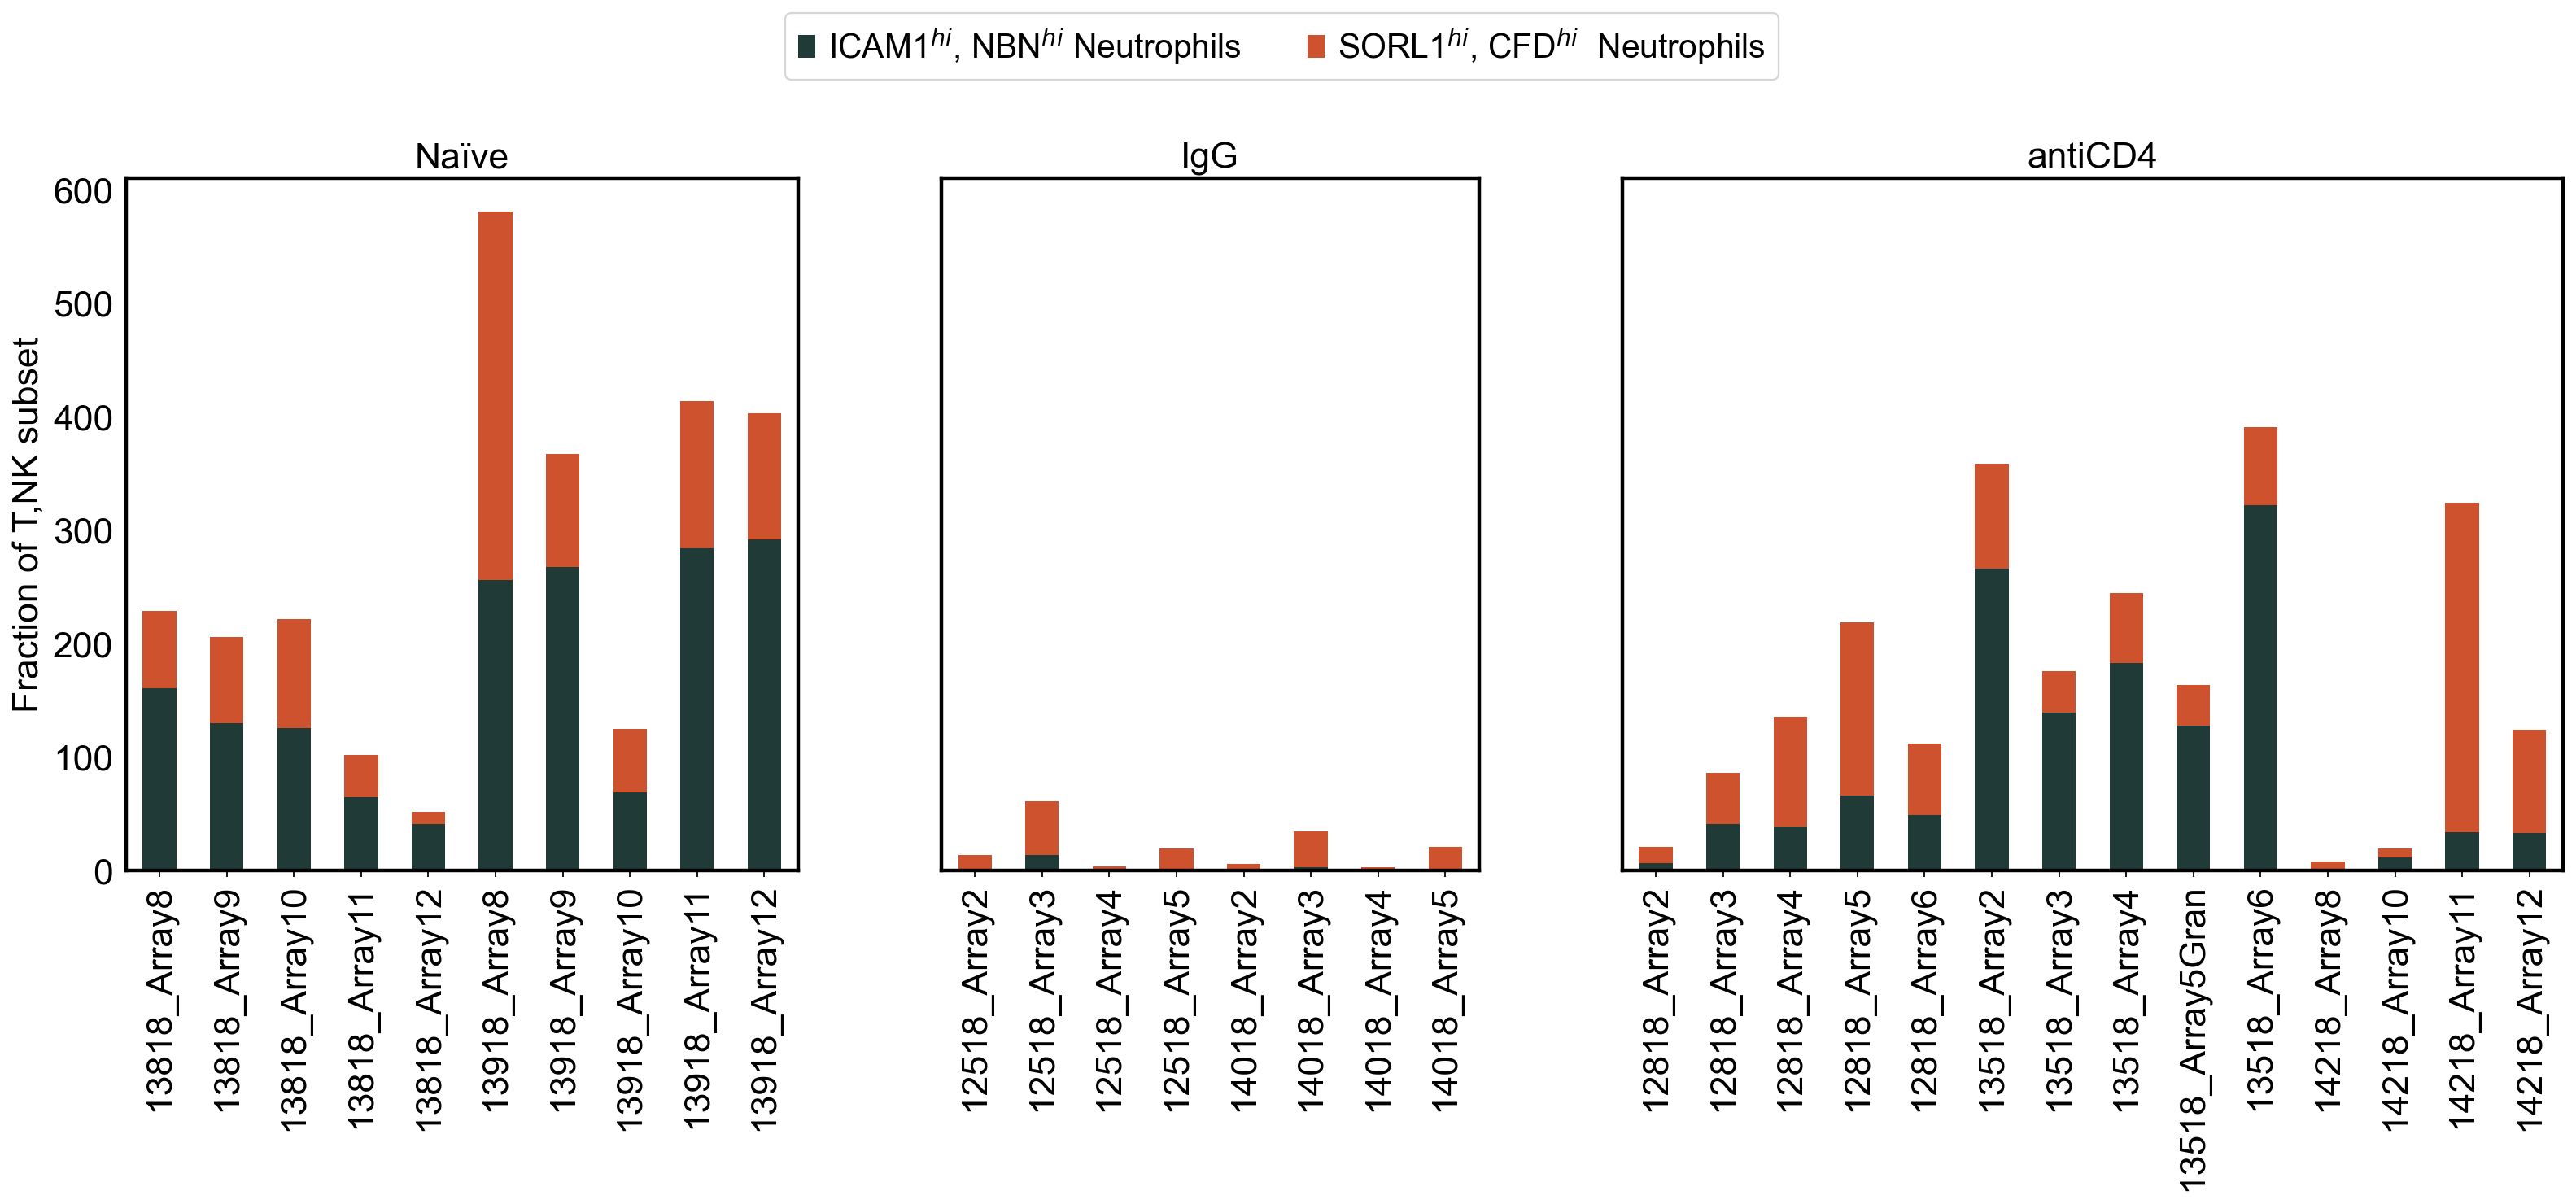

In [19]:
plt.rcParams['axes.linewidth'] = 1.2
grouped_stacked_bars(adata, plot_sep="Group",  x_value='array number', color_value='Subclustering', normalized=False, 
                         figwidth_mult=8, figheight=7, plot_order=["Naïve", "IgG", "antiCD4"], legend=False)
plt.savefig("./Figure6/Associated_Supplemental/Figure6_Neut_Supplemental_CellNumber_Individual_Granuloma_Group.png",bbox_inches="tight",dpi=1000)
